In [1]:
import pandas as pd

In [3]:
df1 = pd.read_excel("./cleaned.xlsx")
print(df1.head())

       TIMESTAMP  TARGETVAR       U10       V10      U100      V100  \
0  20120101 1:00   0.000000  2.124600 -2.681966  2.864280 -3.666076   
1  20120101 2:00   0.054879  2.521695 -1.796960  3.344859 -2.464761   
2  20120101 3:00   0.110234  2.672210 -0.822516  3.508448 -1.214093   
3  20120101 4:00   0.165116  2.457504 -0.143642  3.215233 -0.355546   
4  20120101 5:00   0.156940  2.245898  0.389576  2.957678  0.332701   

             DATETIME  
0 2012-01-01 01:00:00  
1 2012-01-01 02:00:00  
2 2012-01-01 03:00:00  
3 2012-01-01 04:00:00  
4 2012-01-01 05:00:00  


In [6]:
# --- 0) Imports
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

torch.manual_seed(0)
df = df1.drop(columns=["TIMESTAMP","DATETIME"])
print(df.head())
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 1) Your dataframe: df with columns [TIMESTAMP, TARGETVAR, U10, V10, U100, V100]
# If starting from CSV: df = pd.read_csv("your_file.csv")
# We'll build X from the 4 features and y from TARGETVAR.
feat_cols = ["U10","V10","U100","V100"]
target_col = "TARGETVAR"

# --- 2) Split by time (no shuffling) BEFORE scaling to avoid leakage
def time_split(df, train=0.7, val=0.15):
    n = len(df)
    n_train = int(n*train)
    n_val = int(n*(train+val))
    return df.iloc[:n_train], df.iloc[n_train:n_val], df.iloc[n_val:]

df_train, df_val, df_test = time_split(df)

# --- 3) Fit scalers on TRAIN ONLY, then transform all splits
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(df_train[feat_cols].values)
y_train = y_scaler.fit_transform(df_train[[target_col]].values).ravel()

X_val   = x_scaler.transform(df_val[feat_cols].values)
y_val   = y_scaler.transform(df_val[[target_col]].values).ravel()

X_test  = x_scaler.transform(df_test[feat_cols].values)
y_test  = y_scaler.transform(df_test[[target_col]].values).ravel()

print(X_test)
# --- 4) Make sliding windows: input shape (L, 4) -> predict next target
def make_windows(X, y, L=24, horizon=1):
    xs, ys = [], []
    for i in range(L, len(X)-horizon+1):
        xs.append(X[i-L:i])                # (L, n_features)
        ys.append(y[i + horizon - 1])      # scalar target at t+h
    return np.array(xs), np.array(ys)

L = 24          # lookback (hours)
H = 1           # horizon (1 step ahead)
Xtr, ytr = make_windows(X_train, y_train, L, H)
Xva, yva = make_windows(X_val,   y_val,   L, H)
Xte, yte = make_windows(X_test,  y_test,  L, H)

# --- 5) Dataloaders
batch_size = 128
train_loader = DataLoader(TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                                        torch.tensor(ytr, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(TensorDataset(torch.tensor(Xva, dtype=torch.float32),
                                        torch.tensor(yva, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=False, drop_last=False)

# --- 6) LSTM + linear head (no classes)
n_features = len(feat_cols)
hidden = 64
layers = 1

lstm = nn.LSTM(input_size=n_features, hidden_size=hidden, num_layers=layers, batch_first=True).to(DEVICE)
head = nn.Linear(hidden, 1).to(DEVICE)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(list(lstm.parameters()) + list(head.parameters()), lr=1e-3)

# --- 7) Train
epochs = 20
best_val = float("inf")
for ep in range(1, epochs+1):
    # train
    lstm.train(); head.train()
    tr_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        out, _ = lstm(xb)              # out: (B, L, hidden)
        last = out[:, -1, :]           # (B, hidden) -> use last hidden state
        pred = head(last).squeeze(-1)  # (B,)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        tr_loss += loss.item() * len(xb)
    tr_loss /= len(train_loader.dataset)

    # validate
    lstm.eval(); head.eval()
    with torch.no_grad():
        xv = torch.tensor(Xva, dtype=torch.float32).to(DEVICE)
        yv = torch.tensor(yva, dtype=torch.float32).to(DEVICE)
        out, _ = lstm(xv)
        last = out[:, -1, :]
        p = head(last).squeeze(-1)
        val_loss = loss_fn(p, yv).item()

    print(f"epoch {ep:02d} | train_mse={tr_loss:.4f} val_mse={val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        best_state = (lstm.state_dict(), head.state_dict())

# --- 8) Test (invert scaling to get real units)
lstm.load_state_dict(best_state[0]); head.load_state_dict(best_state[1])
lstm.eval(); head.eval()
with torch.no_grad():
    xt = torch.tensor(Xte, dtype=torch.float32).to(DEVICE)
    out, _ = lstm(xt)
    last = out[:, -1, :]
    p_norm = head(last).squeeze(-1).cpu().numpy()      # normalized preds
    y_norm = yte

# inverse transform to original target units
p_real = y_scaler.inverse_transform(p_norm.reshape(-1,1)).ravel()
y_real = y_scaler.inverse_transform(y_norm.reshape(-1,1)).ravel()
rmse  = mean_squared_error(y_real, p_real, squared=False)
print("Test RMSE:", rmse)

# --- 9) Optional: simple multi-step recursive forecast
def forecast_recursive(last_window_X_norm, steps=24):
    """
    last_window_X_norm: np.array shape (L, n_features) in normalized feature space
    returns predictions in ORIGINAL TARGET UNITS (np.array, length=steps)
    """
    win = last_window_X_norm.copy()
    preds_real = []
    for _ in range(steps):
        with torch.no_grad():
            inp = torch.tensor(win[None,...], dtype=torch.float32).to(DEVICE)  # (1, L, n_features)
            out, _ = lstm(inp); last = out[:, -1, :]
            p_norm = head(last).item()                                         # scalar
        p_real = y_scaler.inverse_transform([[p_norm]]).ravel()[0]
        preds_real.append(p_real)
        # NOTE: If you want to use the predicted power as an extra feature later,
        # you'd first add past power to X and shift properly. With only 4 wind features,
        # the window stays unchanged here unless you also roll forward exogenous forecasts.
    return np.array(preds_real)

# Example usage:
# last_window = X_test[-L:, :]            # normalized features window
# next_24h_preds = forecast_recursive(last_window, steps=24)


   TARGETVAR       U10       V10      U100      V100
0   0.000000  2.124600 -2.681966  2.864280 -3.666076
1   0.054879  2.521695 -1.796960  3.344859 -2.464761
2   0.110234  2.672210 -0.822516  3.508448 -1.214093
3   0.165116  2.457504 -0.143642  3.215233 -0.355546
4   0.156940  2.245898  0.389576  2.957678  0.332701
[[ 2.51507988 -2.11489939  2.56033906 -1.96602402]
 [ 2.95036156 -1.44283117  2.8340873  -1.26446821]
 [ 3.42059708 -1.01367204  3.16102009 -0.87359177]
 ...
 [-1.22908687 -1.4133111  -1.15482293 -1.34870734]
 [-1.0927245  -1.61067785 -0.96996442 -1.39258919]
 [-0.8219181  -1.88328191 -0.73409232 -1.58230592]]
epoch 01 | train_mse=nan val_mse=nan
epoch 02 | train_mse=nan val_mse=nan
epoch 03 | train_mse=nan val_mse=nan
epoch 04 | train_mse=nan val_mse=nan
epoch 05 | train_mse=nan val_mse=nan
epoch 06 | train_mse=nan val_mse=nan
epoch 07 | train_mse=nan val_mse=nan
epoch 08 | train_mse=nan val_mse=nan
epoch 09 | train_mse=nan val_mse=nan
epoch 10 | train_mse=nan val_mse=nan


NameError: name 'best_state' is not defined

In [5]:
# --- 0) Imports
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Repro
torch.manual_seed(0)
np.random.seed(0)

# -------------- UTILITIES (NEW) --------------
def coerce_and_clean(df, cols):
    """Coerce to numeric, replace infs, interpolate, drop stubborn NaNs in target."""
    df = df.copy()
    # Coerce non-numeric to NaN
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # Replace +-inf with NaN
    df[cols] = df[cols].replace([np.inf, -np.inf], np.nan)
    # Interpolate (linear); fill edges
    df[cols] = df[cols].interpolate(method="linear", limit_direction="both")
    return df

def chk(name, arr):
    arr = np.asarray(arr)
    print(f"{name:>8} | shape={arr.shape} | any_nan={np.isnan(arr).any()} "
          f"| any_inf={np.isinf(arr).any()} | min={np.nanmin(arr):.4f} | max={np.nanmax(arr):.4f}")

def safe_standardize_fit(train_arr):
    """Fit a StandardScaler and guard zero-variance columns."""
    sc = StandardScaler()
    sc.fit(train_arr)
    # guard zero scale (std=0) → set scale to 1 to avoid div-by-zero
    scale = sc.scale_.copy()
    scale[scale == 0] = 1.0
    sc.scale_ = scale
    return sc

def safe_transform(sc, arr):
    out = sc.transform(arr)
    # replace any rogue NaN/Inf (shouldn't happen after cleaning, but belt & suspenders)
    out = np.nan_to_num(out, copy=False, posinf=0.0, neginf=0.0)
    return out

def make_windows(X, y, L=24, horizon=1):
    xs, ys = [], []
    for i in range(L, len(X)-horizon+1):
        xw = X[i-L:i]                  # (L, n_features)
        yw = y[i + horizon - 1]        # scalar
        if np.isfinite(xw).all() and np.isfinite(yw):
            xs.append(xw)
            ys.append(yw)
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

# --- 1) Your dataframe
# Expecting df1 with columns: ["TIMESTAMP","DATETIME","TARGETVAR","U10","V10","U100","V100"]
# Keep a copy before dropping time columns so we can sort if needed.
assert 'df1' in globals(), "df1 must exist in scope."
# Sort by time if a timestamp exists (optional but good practice)
if "TIMESTAMP" in df1.columns:
    try:
        df1 = df1.copy()
        df1["TIMESTAMP"] = pd.to_datetime(df1["TIMESTAMP"])
        df1 = df1.sort_values("TIMESTAMP")
    except Exception:
        pass

# Drop time columns for modeling
drop_cols = [c for c in ["TIMESTAMP","DATETIME"] if c in df1.columns]
df = df1.drop(columns=drop_cols).copy()

# Feature/target columns
feat_cols = ["U10","V10","U100","V100"]
target_col = "TARGETVAR"
all_cols = [target_col] + feat_cols

# --- (NEW) Clean data before anything else
df = coerce_and_clean(df, all_cols)
# Drop any rows where target is still NaN after interpolation (should be none)
df = df.dropna(subset=[target_col]).reset_index(drop=True)

print("HEAD after cleaning:")
print(df.head())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE =", DEVICE)

# --- 2) Split by time (no shuffling)
def time_split(df, train=0.7, val=0.15):
    n = len(df); n_train = int(n*train); n_val = int(n*(train+val))
    return df.iloc[:n_train], df.iloc[n_train:n_val], df.iloc[n_val:]

df_train, df_val, df_test = time_split(df)

# --- 3) Fit scalers on TRAIN ONLY (NEW: safe scalers)
x_scaler = safe_standardize_fit(df_train[feat_cols].values)
y_scaler = safe_standardize_fit(df_train[[target_col]].values)

X_train = safe_transform(x_scaler, df_train[feat_cols].values)
y_train = safe_transform(y_scaler, df_train[[target_col]].values).ravel()

X_val   = safe_transform(x_scaler, df_val[feat_cols].values)
y_val   = safe_transform(y_scaler, df_val[[target_col]].values).ravel()

X_test  = safe_transform(x_scaler, df_test[feat_cols].values)
y_test  = safe_transform(y_scaler, df_test[[target_col]].values).ravel()

# Sanity prints
chk("X_train", X_train); chk("y_train", y_train)
chk("X_val",   X_val);   chk("y_val",   y_val)
chk("X_test",  X_test);  chk("y_test",  y_test)

# --- 4) Windows
L = 24  # lookback (hours)
H = 1   # horizon (1 step ahead)
Xtr, ytr = make_windows(X_train, y_train, L, H)
Xva, yva = make_windows(X_val,   y_val,   L, H)
Xte, yte = make_windows(X_test,  y_test,  L, H)

chk("Xtr", Xtr); chk("ytr", ytr)
chk("Xva", Xva); chk("yva", yva)
chk("Xte", Xte); chk("yte", yte)

# Hard guards (NEW)
for name, arr in [("Xtr", Xtr), ("ytr", ytr), ("Xva", Xva), ("yva", yva)]:
    assert np.isfinite(arr).all(), f"{name} has non-finite values"

# --- 5) Dataloaders (NEW: pin_memory/num_workers)
batch_size = 128
pin = (DEVICE == "cuda")
train_loader = DataLoader(
    TensorDataset(torch.tensor(Xtr), torch.tensor(ytr)),
    batch_size=batch_size, shuffle=True, drop_last=False,
    num_workers=2, pin_memory=pin
)
val_loader   = DataLoader(
    TensorDataset(torch.tensor(Xva), torch.tensor(yva)),
    batch_size=batch_size, shuffle=False, drop_last=False,
    num_workers=2, pin_memory=pin
)

# --- 6) LSTM + head
n_features = len(feat_cols)
hidden = 64
layers = 1
lstm = nn.LSTM(input_size=n_features, hidden_size=hidden, num_layers=layers, batch_first=True).to(DEVICE)
head = nn.Linear(hidden, 1).to(DEVICE)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(list(lstm.parameters()) + list(head.parameters()), lr=1e-3)

# --- 7) Train (NEW: NaN guards + grad clipping)
epochs = 20
best_val = float("inf")
best_state = None

for ep in range(1, epochs+1):
    lstm.train(); head.train()
    tr_loss_sum, n_items = 0.0, 0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        # Safety: check batch finiteness
        if not torch.isfinite(xb).all() or not torch.isfinite(yb).all():
            print("Skipping bad batch with non-finite values")
            continue

        opt.zero_grad(set_to_none=True)
        out, _ = lstm(xb)                # (B, L, H)
        last = out[:, -1, :]             # (B, H)
        pred = head(last).squeeze(-1)    # (B,)

        loss = loss_fn(pred, yb)
        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN/Inf loss encountered; skipping batch")
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(list(lstm.parameters()) + list(head.parameters()), max_norm=1.0)  # NEW
        opt.step()

        tr_loss_sum += loss.item() * xb.size(0)
        n_items += xb.size(0)

    train_mse = tr_loss_sum / max(n_items, 1)

    # Validate
    lstm.eval(); head.eval()
    with torch.no_grad():
        v_loss_sum, v_items = 0.0, 0
        for xv, yv in val_loader:
            xv = xv.to(DEVICE, non_blocking=True)
            yv = yv.to(DEVICE, non_blocking=True)
            out, _ = lstm(xv)
            last = out[:, -1, :]
            p = head(last).squeeze(-1)
            loss = loss_fn(p, yv)
            v_loss_sum += loss.item() * xv.size(0)
            v_items += xv.size(0)
        val_mse = v_loss_sum / max(v_items, 1)

    print(f"epoch {ep:02d} | train_mse={train_mse:.6f} val_mse={val_mse:.6f}")

    if np.isfinite(val_mse) and val_mse < best_val:
        best_val = val_mse
        best_state = (lstm.state_dict(), head.state_dict())

# --- 8) Test
if best_state is not None:
    lstm.load_state_dict(best_state[0]); head.load_state_dict(best_state[1])

lstm.eval(); head.eval()
with torch.no_grad():
    xt = torch.tensor(Xte).to(DEVICE)
    out, _ = lstm(xt)
    last = out[:, -1, :]
    p_norm = head(last).squeeze(-1).cpu().numpy()  # normalized preds
    y_norm = yte

# inverse transform to original units
p_real = y_scaler.inverse_transform(p_norm.reshape(-1,1)).ravel()
y_real = y_scaler.inverse_transform(y_norm.reshape(-1,1)).ravel()
mse = mean_squared_error(y_real, p_real)
rmse = float(np.sqrt(mse))
print("Test RMSE:", rmse)

print("Test RMSE:", rmse)

# --- 9) Optional: recursive forecast (unchanged, but robust to scaling)
def forecast_recursive(last_window_X_norm, steps=24):
    """
    last_window_X_norm: np.array shape (L, n_features) in normalized feature space
    returns predictions in ORIGINAL TARGET UNITS (np.array, length=steps)
    """
    win = last_window_X_norm.copy()
    preds_real = []
    for _ in range(steps):
        with torch.no_grad():
            inp = torch.tensor(win[None,...], dtype=torch.float32).to(DEVICE)
            out, _ = lstm(inp); last = out[:, -1, :]
            p_norm = head(last).item()
        p_real = y_scaler.inverse_transform([[p_norm]]).ravel()[0]
        preds_real.append(p_real)
        # If you later include the target as a feature, roll it here.
    return np.array(preds_real)


HEAD after cleaning:
   TARGETVAR       U10       V10      U100      V100
0   0.000000  2.124600 -2.681966  2.864280 -3.666076
1   0.054879  2.521695 -1.796960  3.344859 -2.464761
2   0.110234  2.672210 -0.822516  3.508448 -1.214093
3   0.165116  2.457504 -0.143642  3.215233 -0.355546
4   0.156940  2.245898  0.389576  2.957678  0.332701
DEVICE = cpu
 X_train | shape=(11760, 4) | any_nan=False | any_inf=False | min=-3.4985 | max=4.1205
 y_train | shape=(11760,) | any_nan=False | any_inf=False | min=-1.0217 | max=2.5733
   X_val | shape=(2520, 4) | any_nan=False | any_inf=False | min=-3.1711 | max=3.4910
   y_val | shape=(2520,) | any_nan=False | any_inf=False | min=-1.0217 | max=2.5750
  X_test | shape=(2520, 4) | any_nan=False | any_inf=False | min=-2.8905 | max=4.0607
  y_test | shape=(2520,) | any_nan=False | any_inf=False | min=-1.0217 | max=2.5740
     Xtr | shape=(11736, 24, 4) | any_nan=False | any_inf=False | min=-3.4985 | max=4.1205
     ytr | shape=(11736,) | any_nan=False | a

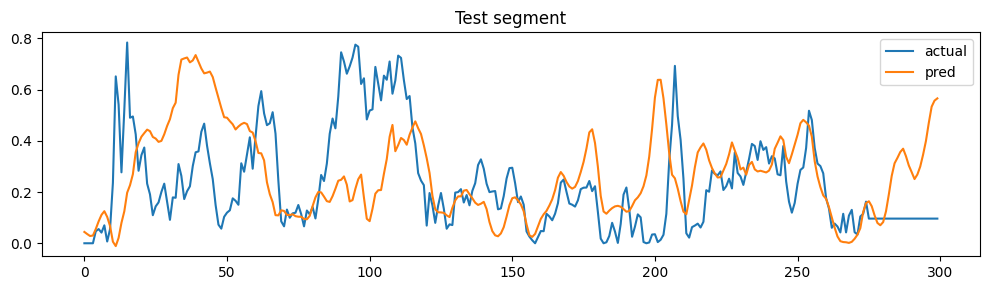

In [6]:
import matplotlib.pyplot as plt

k = min(300, len(y_real))   # plot last 300 points
plt.figure(figsize=(10,3))
plt.plot(y_real[-k:], label="actual")
plt.plot(p_real[-k:], label="pred")
plt.legend(); plt.title("Test segment"); plt.tight_layout(); plt.show()
